## Homework 5

1. In this notebook, we learned the various components of an LLM. 
    Your homework this week is to take the mini LLM we created from scratch and run your own training loop. Show how the training and validation perplexity change over the steps.
      
    Hint: this function might be useful for you:

In [1]:
import os
os.environ["HTTP_PROXY"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["HTTPS_PROXY"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["http_proxy"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["https_proxy"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["ftp_proxy"]="http://proxy-01.pub.alcf.anl.gov:3128" 

In [2]:
import torch
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

## Let's train a mini-LLM from scratch

### Set up hyperparameters:

In [3]:
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 10
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4
dropout = 0.0
# ------------

### Load in data and create train and test datasets

We're going to be using the tiny Shakespeare dataset. 
Data is tokenized according to a simple character based tokenizer.
Data is split into a train and test set so we have something to test after performing training (9:1 split).

In [4]:
with open('dataset/input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

### Set up the components of the Decoder block: 
* MultiHeadAttention
* FeedForward Network

In [5]:
import torch
import torch.nn as nn
from torch.nn import functional as F

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C) 16,32,16
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd), # Projection layer going back into the residual pathway
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


### Combine components into the Decoder block

In [6]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))    # Communication
        x = x + self.ffwd(self.ln2(x))  # Computation
        return x

### Set up the full Transformer model 
This is a combination of the Token embeddings, Positional embeddings, a stack of Transformer blocks and an output block.

In [7]:
# super simple language model
class LanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx



In [8]:
# Define training loop and train model
model = LanguageModel().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss = nn.CrossEntropyLoss()

train_perplex = []
val_perplex = []

for i in range(max_iters+1):
    x, y = get_batch('train')
    logits, train_loss = model(x, y)
    
    #append train perplexity 
    train_perplex.append(torch.exp(train_loss).item())
    
    opt.zero_grad() 
    x, y = get_batch('val')
    logits, val_loss = model(x, y)
    val_perplex.append(torch.exp(val_loss).item())
    
    # Update parameters
    train_loss.backward()
    opt.step()
    
    model.train()
    

    if i % 500 == 0:
        print(f'iteration {i}, val loss: {val_loss.item()}')

iteration 0, val loss: 4.354959487915039
iteration 500, val loss: 2.2928545475006104
iteration 1000, val loss: 2.112313985824585
iteration 1500, val loss: 2.1601486206054688
iteration 2000, val loss: 2.013291120529175
iteration 2500, val loss: 1.8758480548858643
iteration 3000, val loss: 1.8797060251235962
iteration 3500, val loss: 1.8810615539550781
iteration 4000, val loss: 1.8752267360687256
iteration 4500, val loss: 1.8841513395309448
iteration 5000, val loss: 1.8735897541046143


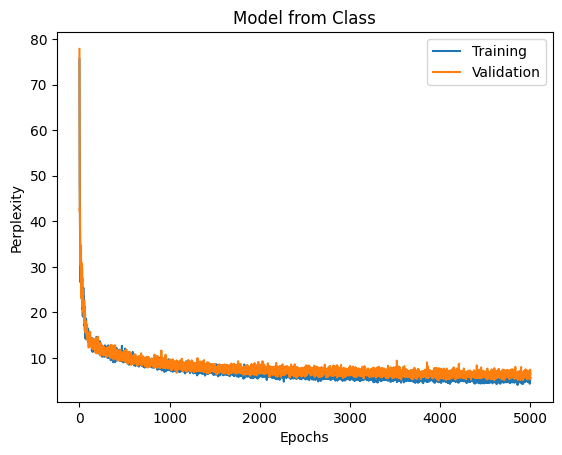

In [9]:
# #Plot trainig and loss perplexity 
import matplotlib.pyplot as plt

plt.plot(train_perplex,label='Training')
plt.plot(val_perplex,label='Validation')

plt.title('Model from Class')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.legend()
plt.show()

## 2. Run the same training loop but modify one of the hyperparameters from this list: 

In [10]:
# hyperparameters
n_embd = 64
n_head = 4 
n_layer = 2 ## Modificaiton 1

# Oriohyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 10
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
# n_embd = 64
# n_head = 4 ## so head_size = 16
# n_layer = 4
dropout = 0.0
# ------------

In [11]:
# Define training loop and train model
model_1 = LanguageModel().to(device)
opt_1 = torch.optim.AdamW(model_1.parameters(), lr=learning_rate)
loss_1 = nn.CrossEntropyLoss()

train_perplex_mod_1 = []
val_perplex_mod_1 = []

for i in range(max_iters+1):
    ## Evaluate the model
    opt_1.zero_grad() 
    x, y = get_batch('val')
    logits, val_loss = model_1(x, y)
    val_perplex_mod_1.append(torch.exp(val_loss).item())
    
    ## Set the model in training mode
    model_1.train()
    x, y = get_batch('train')
    logits, train_loss = model_1(x, y)
    
    #append train perplexity 
    train_perplex_mod_1.append(torch.exp(train_loss).item())
    
    # Update parameters
    train_loss.backward()
    opt_1.step()
    


    if i % 500 == 0:
        print(f'iteration {i}, val loss: {val_loss.item()}')

iteration 0, val loss: 4.327077865600586
iteration 500, val loss: 2.3317718505859375
iteration 1000, val loss: 2.153980255126953
iteration 1500, val loss: 2.103806257247925
iteration 2000, val loss: 2.012335777282715
iteration 2500, val loss: 2.064281940460205
iteration 3000, val loss: 2.049433469772339
iteration 3500, val loss: 1.9364864826202393
iteration 4000, val loss: 1.8010458946228027
iteration 4500, val loss: 1.8737109899520874
iteration 5000, val loss: 1.812048077583313


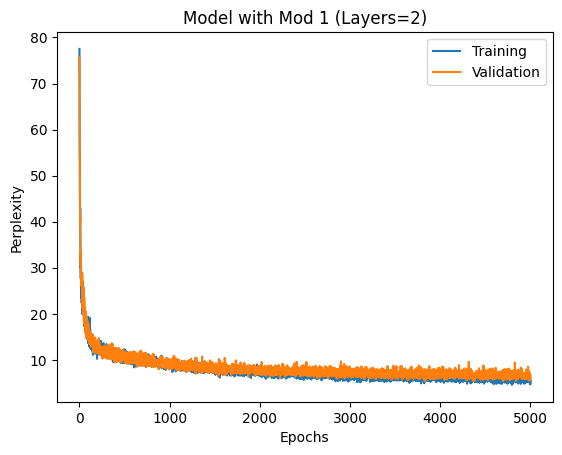

In [12]:
# #Plot trainig and loss perplexity 
import matplotlib.pyplot as plt

plt.plot(train_perplex_mod_1,label='Training')
plt.plot(val_perplex_mod_1,label='Validation')

plt.title('Model with Mod 1 (Layers=2)')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
#plt.yscale('log')
plt.legend()
plt.show()

Run this at least 4 times with a different value and plot each perplexity over training step. Write a sentence on how the perplexity changed.

In [13]:
# hyperparameters
n_embd = 64
n_head = 4 
n_layer = 5 ## Modificaiton 2

# Oriohyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 10
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
# n_embd = 64
# n_head = 4 ## so head_size = 16
# n_layer = 4
dropout = 0.0
# ------------

In [14]:
# Define training loop and train model
model_2 = LanguageModel().to(device)
opt_2 = torch.optim.AdamW(model_2.parameters(), lr=learning_rate)
loss_2 = nn.CrossEntropyLoss()

train_perplex_mod_2 = []
val_perplex_mod_2 = []

for i in range(max_iters+1):

    ## Evaluate the model
    opt_2.zero_grad() 
    x, y = get_batch('val')
    logits, val_loss = model_2(x, y)
    val_perplex_mod_2.append(torch.exp(val_loss).item())
    
    ## Set the model in training mode
    model_2.train()
    x, y = get_batch('train')
    logits, train_loss = model_2(x, y)
    
    #append train perplexity 
    train_perplex_mod_2.append(torch.exp(train_loss).item())
    
    # Update parameters
    train_loss.backward()
    opt_2.step()
    
    if i % 500 == 0:
        print(f'iteration {i}, val loss: {val_loss.item()}')

iteration 0, val loss: 4.362607002258301
iteration 500, val loss: 2.3747658729553223
iteration 1000, val loss: 1.996012806892395
iteration 1500, val loss: 1.9648197889328003
iteration 2000, val loss: 1.8800196647644043
iteration 2500, val loss: 1.9761731624603271
iteration 3000, val loss: 1.9658665657043457
iteration 3500, val loss: 1.8905445337295532
iteration 4000, val loss: 1.8898524045944214
iteration 4500, val loss: 1.8016668558120728
iteration 5000, val loss: 1.728858232498169


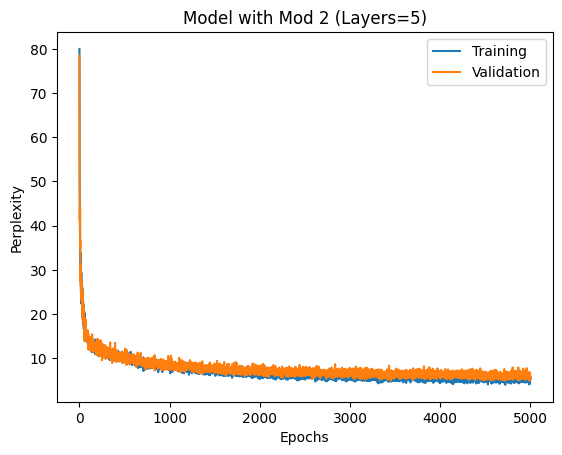

In [15]:
# #Plot trainig and loss perplexity 
import matplotlib.pyplot as plt

plt.plot(train_perplex_mod_2,label='Training')
plt.plot(val_perplex_mod_2,label='Validation')

plt.title('Model with Mod 2 (Layers=5)')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
#plt.yscale('log')
plt.legend()
plt.show()

In [16]:
# hyperparameters
n_embd = 32 ## Modificaiton 3
n_head = 4 
n_layer = 4 

# Oriohyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 10
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
# n_embd = 64
# n_head = 4 ## so head_size = 16
# n_layer = 4
dropout = 0.0
# ------------

# Define training loop and train model
model_3 = LanguageModel().to(device)
opt_3 = torch.optim.AdamW(model_3.parameters(), lr=learning_rate)
loss_3 = nn.CrossEntropyLoss()

train_perplex_mod_3 = []
val_perplex_mod_3 = []

for i in range(max_iters+1):
     ## Evaluate the model
    opt_3.zero_grad() 
    x, y = get_batch('val')
    logits, val_loss = model_3(x, y)
    val_perplex_mod_3.append(torch.exp(val_loss).item())
    
    ## Set the model in training mode
    model_3.train()
    x, y = get_batch('train')
    logits, train_loss = model_3(x, y)
    
    #append train perplexity 
    train_perplex_mod_3.append(torch.exp(train_loss).item())
    
    # Update parameters
    train_loss.backward()
    opt_3.step()
    if i % 500 == 0:
        print(f'iteration {i}, val loss: {val_loss.item()}')

iteration 0, val loss: 4.363372802734375
iteration 500, val loss: 2.506479501724243
iteration 1000, val loss: 2.3665771484375
iteration 1500, val loss: 2.301055669784546
iteration 2000, val loss: 2.1639301776885986
iteration 2500, val loss: 2.2617971897125244
iteration 3000, val loss: 2.041426181793213
iteration 3500, val loss: 1.9999463558197021
iteration 4000, val loss: 2.0055043697357178
iteration 4500, val loss: 2.044666051864624
iteration 5000, val loss: 2.0070693492889404


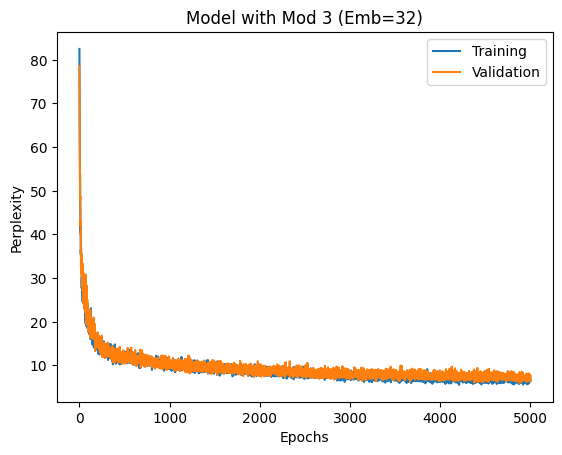

In [17]:
# #Plot trainig and loss perplexity 
import matplotlib.pyplot as plt

plt.plot(train_perplex_mod_3,label='Training')
plt.plot(val_perplex_mod_3,label='Validation')

plt.title('Model with Mod 3 (Emb=32)')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
#plt.yscale('log')
plt.legend()
plt.show()

In [18]:
# hyperparameters
n_embd = 64 
n_head = 8 ## Modificaiton 4
n_layer = 4 

# Oriohyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 10
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
# n_embd = 64
# n_head = 4 ## so head_size = 16
# n_layer = 4
dropout = 0.0
# ------------

# Define training loop and train model
model_4 = LanguageModel().to(device)
opt_4 = torch.optim.AdamW(model_4.parameters(), lr=learning_rate)
loss_4 = nn.CrossEntropyLoss()

train_perplex_mod_4 = []
val_perplex_mod_4 = []

for i in range(max_iters+1):
     ## Evaluate the model
    opt_4.zero_grad() 
    x, y = get_batch('val')
    logits, val_loss = model_4(x, y)
    val_perplex_mod_4.append(torch.exp(val_loss).item())
    
    ## Set the model in training mode
    model_4.train()
    x, y = get_batch('train')
    logits, train_loss = model_4(x, y)
    
    #append train perplexity 
    train_perplex_mod_4.append(torch.exp(train_loss).item())
    
    # Update parameters
    train_loss.backward()
    opt_4.step()
    if i % 500 == 0:
        print(f'iteration {i}, val loss: {val_loss.item()}')

iteration 0, val loss: 4.379708290100098
iteration 500, val loss: 2.262484550476074
iteration 1000, val loss: 2.2481629848480225
iteration 1500, val loss: 2.0137383937835693
iteration 2000, val loss: 2.0348355770111084
iteration 2500, val loss: 2.001444101333618
iteration 3000, val loss: 2.01942777633667
iteration 3500, val loss: 1.8810665607452393
iteration 4000, val loss: 1.9350125789642334
iteration 4500, val loss: 1.8761563301086426
iteration 5000, val loss: 1.9633820056915283


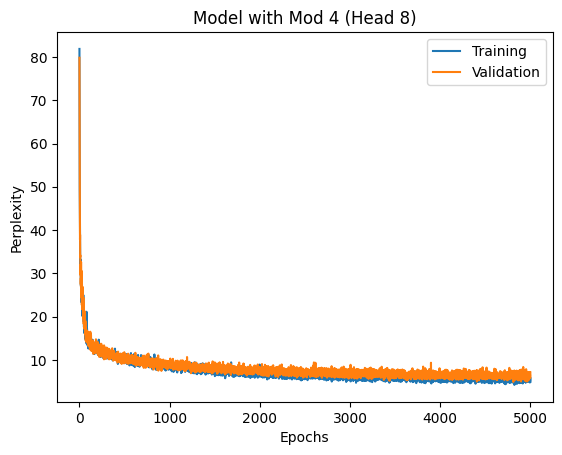

In [19]:
# #Plot trainig and loss perplexity 
import matplotlib.pyplot as plt

plt.plot(train_perplex_mod_4,label='Training')
plt.plot(val_perplex_mod_4,label='Validation')

plt.title('Model with Mod 4 (Head 8)')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
#plt.yscale('log')
plt.legend()
plt.show()

In [20]:
# hyperparameters
n_embd = 64 ## Modificaiton 5
n_head = 8
n_layer = 8

# Oriohyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 10
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
# n_embd = 64
# n_head = 4 ## so head_size = 16
# n_layer = 4
dropout = 0.0
# ------------

# Define training loop and train model
model_5 = LanguageModel().to(device)
opt_5 = torch.optim.AdamW(model_5.parameters(), lr=learning_rate)
loss_5 = nn.CrossEntropyLoss()

train_perplex_mod_5 = []
val_perplex_mod_5 = []

for i in range(max_iters+1):
     ## Evaluate the model
    opt_5.zero_grad() 
    x, y = get_batch('val')
    logits, val_loss = model_5(x, y)
    val_perplex_mod_5.append(torch.exp(val_loss).item())
    
    ## Set the model in training mode
    model_5.train()
    x, y = get_batch('train')
    logits, train_loss = model_5(x, y)
    
    #append train perplexity 
    train_perplex_mod_5.append(torch.exp(train_loss).item())
    
    # Update parameters
    train_loss.backward()
    opt_5.step()
    if i % 500 == 0:
        print(f'iteration {i}, val loss: {val_loss.item()}')

iteration 0, val loss: 4.345328330993652
iteration 500, val loss: 2.3119957447052
iteration 1000, val loss: 2.175961971282959
iteration 1500, val loss: 2.1887168884277344
iteration 2000, val loss: 1.8923254013061523
iteration 2500, val loss: 1.9503203630447388
iteration 3000, val loss: 1.7719148397445679
iteration 3500, val loss: 1.8530913591384888
iteration 4000, val loss: 1.973923921585083
iteration 4500, val loss: 1.8832019567489624
iteration 5000, val loss: 1.7012377977371216


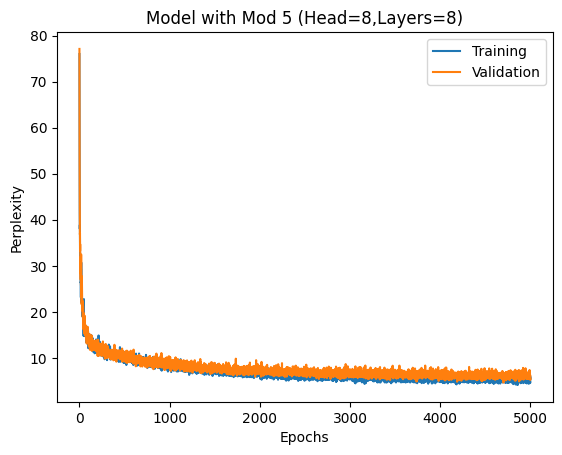

In [21]:
# #Plot trainig and loss perplexity 
import matplotlib.pyplot as plt

plt.plot(train_perplex_mod_5,label='Training')
plt.plot(val_perplex_mod_5,label='Validation')

plt.title('Model with Mod 5 (Head=8,Layers=8)')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
#plt.yscale('log')
plt.legend()
plt.show()

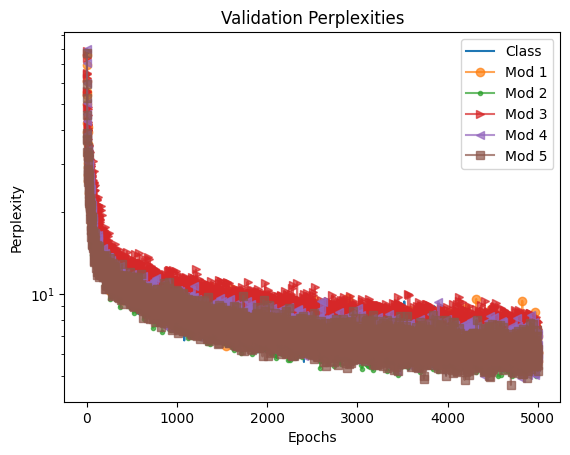

In [35]:
## plot all the validation perplexities 


# #Plot trainig and loss perplexity 
import matplotlib.pyplot as plt
plt.plot(val_perplex,label='Class')
plt.plot(val_perplex_mod_1,label='Mod 1',linestyle='-',marker='o',alpha=0.7)
plt.plot(val_perplex_mod_2,label='Mod 2',linestyle='-',marker='.',alpha=0.7)
plt.plot(val_perplex_mod_3,label='Mod 3',linestyle='-',marker='>',alpha=0.7)
plt.plot(val_perplex_mod_4,label='Mod 4',linestyle='-',marker='<',alpha=0.7)
plt.plot(val_perplex_mod_5,label='Mod 5',linestyle='-',marker='s',alpha=0.7)

plt.title('Validation Perplexities')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.yscale('log')
plt.legend()
plt.show()

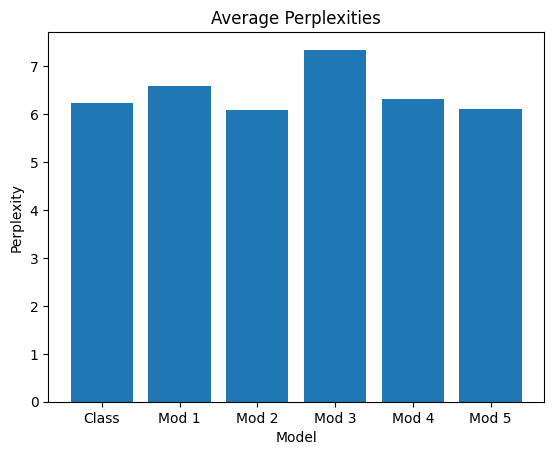

In [37]:
import numpy as np
perplexities = [np.mean(val_perplex[-100:]),np.mean(val_perplex_mod_1[-100:]),np.mean(val_perplex_mod_2[-100:]),np.mean(val_perplex_mod_3[-100:]),np.mean(val_perplex_mod_4[-100:]),np.mean(val_perplex_mod_5[-100:])]
labels = ['Class','Mod 1','Mod 2','Mod 3','Mod 4','Mod 5']
plt.bar(labels,perplexities)
plt.title('Average Perplexities')
plt.xlabel('Model')
plt.ylabel('Perplexity')

plt.show()

Discussion 

Increasing the number of layers shows improvements in the perplexity of the model, as shown with modification 2, and the opossite showed to be true with modification 1. THis result sugest tincreasing layer makes the model capable of identofying more complex paterns. Decreasing the value of the embdding had a sligh negative effect on the perplexity values (Mod 3). Increasing the number of heads had positive effect on the perplexity and this are related to the models  capacity to focous on different parts of the sequence input. Similarly, increasing the number of heads and layers had a positive improvement on the perplexity of the models as well as in its focus and understanding on the context, as seen in MOdification 4 and 5. 